# SIADS Milestone I

- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **Yao Tong (tonyao@umich.edu)**, School of Information, University of Michigan



In [1]:
import sys, os
import json
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import itertools
import nltk
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import pearsonr
from boto3.dynamodb.types import TypeDeserializer
sys.path.append(os.getcwd() + "/src")
from src.pj_config.dynamo_db_client import get_dynamo_db_client
from decimal import Decimal

# 1. Data Improt

In [2]:
def convert_dynamodb_response(response):
    deserializer = TypeDeserializer()
    def parse_item(item):
        return {key: deserializer.deserialize(value) for key, value in item.items()}
  
    items_temp = [parse_item(item) for item in items]
    df = pd.DataFrame(items_temp)
    df = df.applymap(lambda x: x if not isinstance(x, dict) else x.get('S', x))
    return df
    
dynamodb = get_dynamo_db_client()
response = dynamodb.scan(TableName='tiktok_trending')

items=response["Items"]

while 'LastEvaluatedKey' in response and response['LastEvaluatedKey'] != "":  
    response = dynamodb.scan(TableName='tiktok_trending', ExclusiveStartKey=response['LastEvaluatedKey'])
    items.extend(response["Items"])
df = convert_dynamodb_response(items)


# 2. Data Cleaning & Data Manipulation

In [3]:
###### User
user_df = df[['id', 'createTime', 'authorMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]

In [4]:
###### Music
music_df = df[['id', 'createTime', 'musicMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]

In [5]:
###### Video
video_df = df[['id', 'createTime', 'videoMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]
video_df = video_df.copy()

video_df['videoMeta'] = video_df['videoMeta'].apply(lambda x: {'width': int(x['width']), 'duration': int(x['duration']), 'height': int(x['height'])})
video_df[['video_width', 'video_duration', 'video_height']] = pd.DataFrame(video_df['videoMeta'].tolist())

video_df['video_duration'] = video_df['video_duration'].astype(float)
video_df['diggCount'] = video_df['diggCount'].astype(float)
video_df['shareCount'] = video_df['shareCount'].astype(float)
video_df['playCount'] = video_df['playCount'].astype(float)
video_df['commentCount'] = video_df['commentCount'].astype(float)

In [16]:
###### Text
text_df = df[['id', 'createTime', 'text', 'mentions', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]

def process_numeric_column(df, column_name):
    df.loc[:, column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df_copy = df.copy()
    quantiles = df_copy[column_name].quantile([0, 1/5, 2/5, 3/5, 4/5, 1])
    df_copy[f'{column_name}Category'] = pd.cut(df_copy[column_name], bins=quantiles, labels=['very low', 'low', 'medium', 'high', 'very high'], include_lowest=True)
    return df_copy
    
text_df = process_numeric_column(text_df, 'diggCount')
text_df = process_numeric_column(text_df, 'commentCount')
text_df = process_numeric_column(text_df, 'shareCount')
text_df = process_numeric_column(text_df, 'playCount')

def extract_hashtags(text):
    return re.findall(r'#(\w+)', text)

unique_hashtags = set()
for text in text_df['text']:
    unique_hashtags.update(extract_hashtags(text))
print(text_df)

                      id  createTime  \
0    6904256013650758914  1607522373   
1    6907464609116982529  1608269434   
2    6903994055907118338  1607461382   
3    6878330292701121794  1601486071   
4    6879699550303538434  1601804876   
..                   ...         ...   
995  6897593866283650306  1605971221   
996  6901833660224326914  1606958377   
997  6904227603067047170  1607515758   
998  6906841661821717762  1608124391   
999  6880592183720676614  1602012740   

                                                  text        mentions  \
0    Storytime #vjp #voorjou #fyp #foryou #dutch #t...              []   
1    #kesfet #turkish #asianmakeup #foryou #viral #...              []   
2             It's always the most difficult workout 😬              []   
3    #nlunatics #yinyang_fantasyworld #terrorkanita...              []   
4                                                                   []   
..                                                 ...             ...   
9

# 3. Analysis

In [7]:
###### User

In [8]:
###### Music

In [9]:
###### Video
def correlation_analysis(column_name):
    correlation_coefficient, _ = pearsonr(video_df['video_duration'], video_df[column_name])
    return correlation_coefficient

digg_corr = correlation_analysis('diggCount')
share_corr = correlation_analysis('shareCount')
play_corr = correlation_analysis('playCount')
comment_corr = correlation_analysis('commentCount')
print("Correlation Coefficient Calculated by pearsonr")

print(f"Correlation Coefficient (video_duration vs diggCount): {digg_corr}")
print(f"Correlation Coefficient (video_duration vs shareCount): {share_corr}")
print(f"Correlation Coefficient (video_duration vs playCount): {play_corr}")
print(f"Correlation Coefficient (video_duration vs commentCount): {comment_corr}")

X = video_df[['diggCount', 'shareCount', 'playCount', 'commentCount']]
y = video_df['video_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {metrics.r2_score(y_test, y_pred)}")
print(f"P-values: {model.coef_}")  # Note: scikit-learn doesn't directly provide p-values


Correlation Coefficient Calculated by pearsonr
Correlation Coefficient (video_duration vs diggCount): -0.03182350874085469
Correlation Coefficient (video_duration vs shareCount): -0.03577975972668335
Correlation Coefficient (video_duration vs playCount): -0.040398100014135324
Correlation Coefficient (video_duration vs commentCount): -0.02458473621613827
Coefficients: [ 2.53749093e-06 -7.47421296e-06 -3.29234688e-07 -7.40084732e-06]
Intercept: 19.61568966988513
R-squared: -0.025691163536808448
P-values: [ 2.53749093e-06 -7.47421296e-06 -3.29234688e-07 -7.40084732e-06]


In [17]:
###### Text
def conditional_probability(df, condition_column, condition_value, target_column, target_value):
    filtered_data = df[df[condition_column].apply(lambda x: condition_value in x)]
    total_occurrences = len(filtered_data)
    target_occurrences = len(filtered_data[filtered_data[target_column] == target_value])
    
    if total_occurrences == 0:
        probability = 0  # Avoid division by zero
    else:
        probability = target_occurrences / total_occurrences
    if(probability > 0):
        result_df = pd.DataFrame([[target_column, target_value, condition_value, probability]],
                                 columns=['TargetColumn', 'TargetValue', 'Hashtag', 'Probability'])
        return result_df

text_result_dfs = []
categories = ['diggCountCategory', 'shareCountCategory', 'playCountCategory', 'commentCountCategory']
target_values = ['very low', 'low', 'medium', 'high', 'very high']
for category in categories:
    for hashtag in unique_hashtags:
        for target_value in target_values:
            text_result_df = conditional_probability(text_df, 'text', hashtag, category, target_value)
            text_result_dfs.append(text_result_df)
text_df2 = pd.concat(text_result_dfs, ignore_index=True)
print(text_df2.head(50))

         TargetColumn TargetValue                Hashtag  Probability
0   diggCountCategory   very high           bebestiktoks     1.000000
1   diggCountCategory         low            fitnesstips     0.333333
2   diggCountCategory      medium            fitnesstips     0.333333
3   diggCountCategory        high            fitnesstips     0.333333
4   diggCountCategory         low            justcurious     1.000000
5   diggCountCategory    very low                aldatma     1.000000
6   diggCountCategory        high         tiktokwellness     1.000000
7   diggCountCategory      medium                  ميرنا     1.000000
8   diggCountCategory   very high                   a380     1.000000
9   diggCountCategory      medium                 satire     1.000000
10  diggCountCategory    very low          peakyblinders     1.000000
11  diggCountCategory        high               hairlook     1.000000
12  diggCountCategory    very low                 ahajla     1.000000
13  diggCountCategor

# 4. Data Visualisation

In [11]:
###### User

In [12]:
###### Music

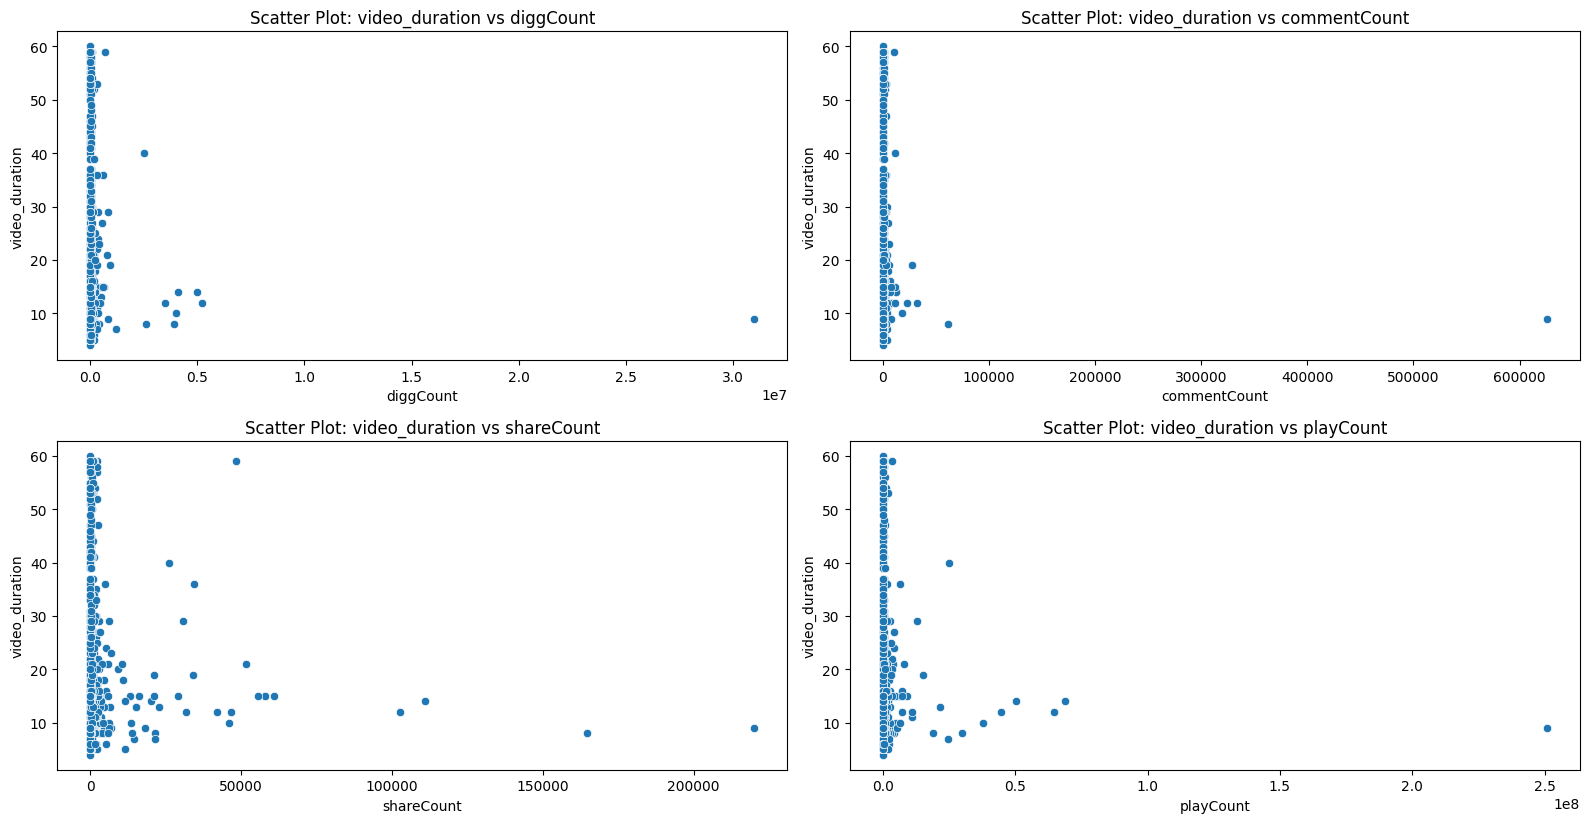

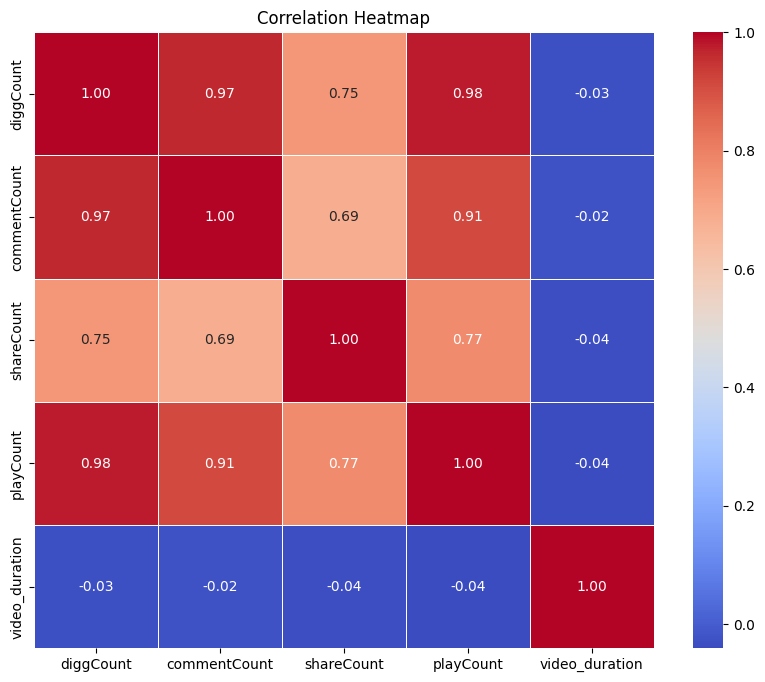

In [13]:
###### Video
num_cols = ["diggCount", "commentCount", "shareCount", "playCount"]
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols, start=1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=col, y='video_duration', data=video_df)
    plt.title(f'Scatter Plot: video_duration vs {col}')

plt.tight_layout()
plt.show()


# Correlation heatmap
video_new_df = video_df[["diggCount", "commentCount", "shareCount", "playCount", "video_duration"]]
plt.figure(figsize=(10, 8))
correlation_matrix = video_new_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


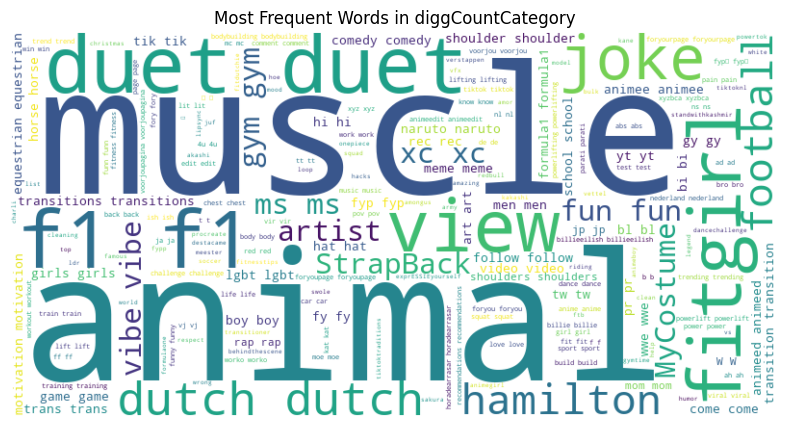

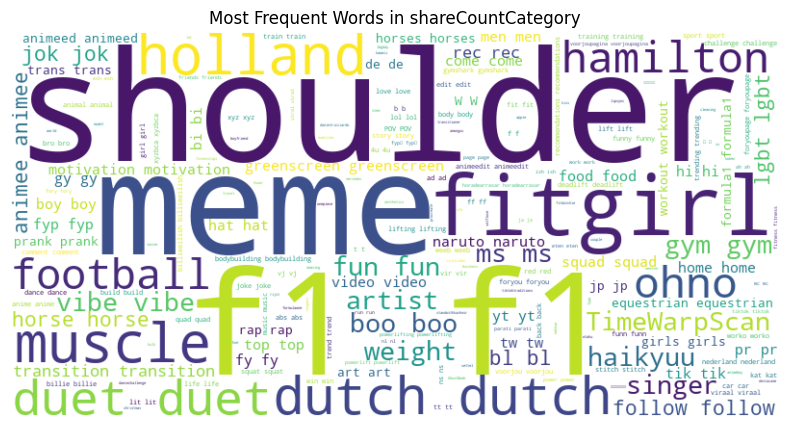

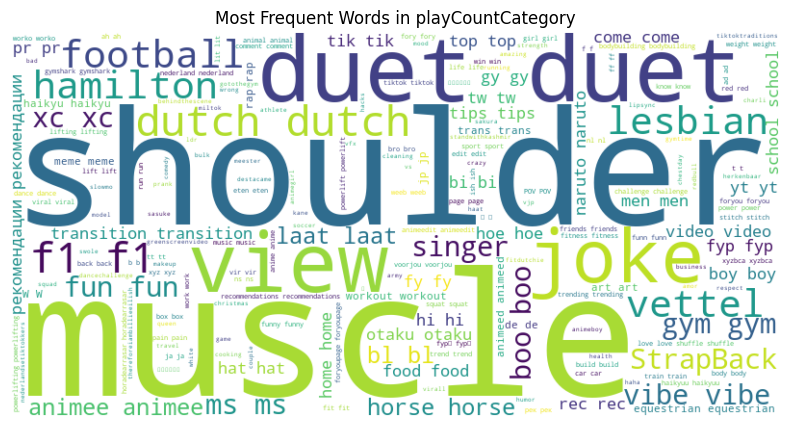

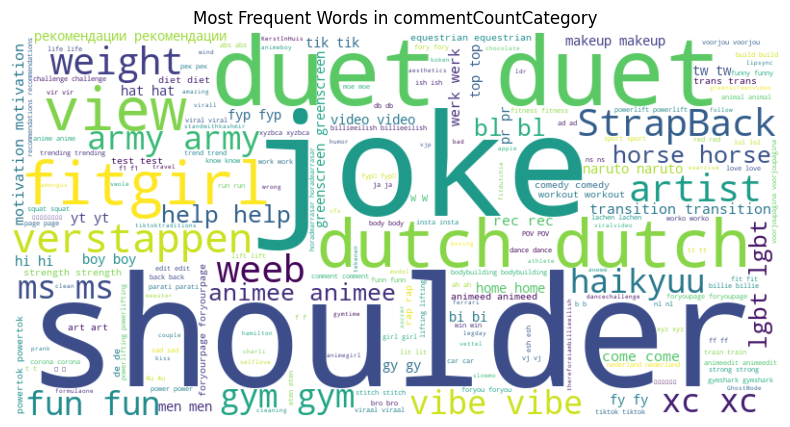

/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3508 (\N{SINHALA LETTER ALPAPRAANA PAYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools

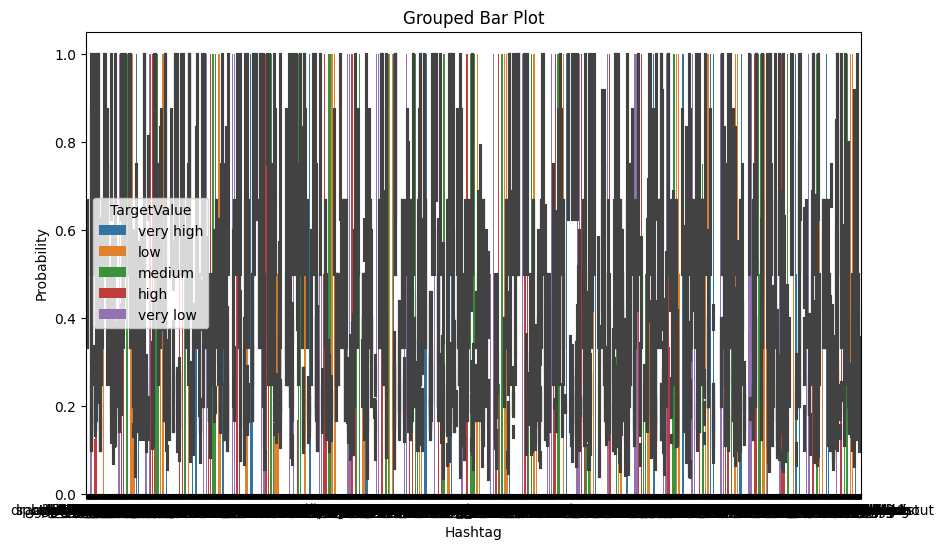

/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3508 (\N{SINHALA LETTER ALPAPRAANA PAYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/IPython/core/pylabtools

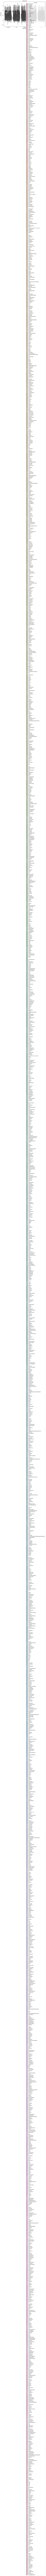

/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/cydiatsang/IdeaProjects/untitled/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

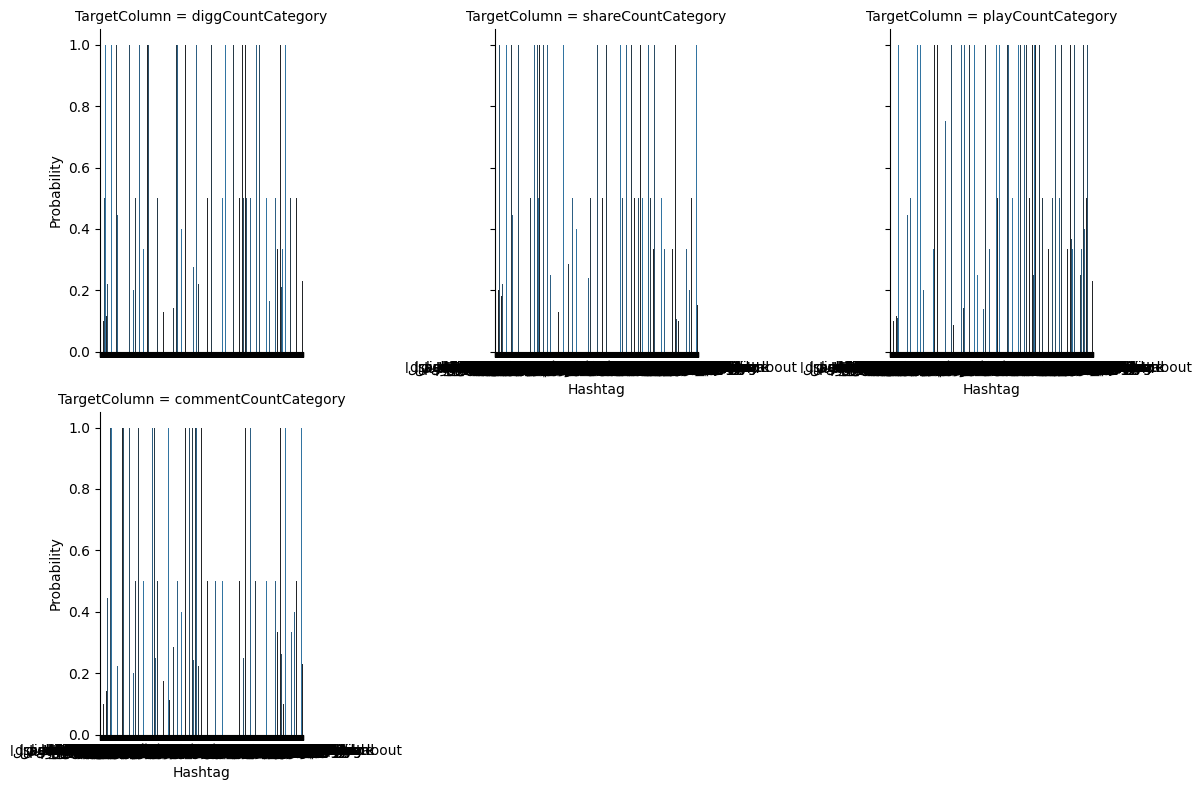

In [15]:
###### Text
categories = text_df2['TargetColumn'].unique()
for category in categories:
    subset = text_df2[text_df2['TargetColumn'] == category]
    text = ' '.join(subset['Hashtag'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words in {category}')
    plt.axis('off')
    plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Hashtag', y='Probability', hue='TargetValue', data=text_df2)
plt.title('Grouped Bar Plot')
plt.show()

# Option 2: Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='TargetValue', y='Probability', hue='Hashtag', data=text_df2, split=True)
plt.title('Violin Plot')
plt.show()

# Option 3: Facet Grid with multiple bar plots
g = sns.FacetGrid(text_df2, col='TargetColumn', col_wrap=3, height=4)
g.map(sns.barplot, 'Hashtag', 'Probability', 'TargetValue')
g.set_axis_labels('Hashtag', 'Probability')
plt.show()